## 本筆記將探討一些影像分類的建模技巧。我們練習的資料集為CIFAR10。

CIFAR10資料集：https://www.cs.toronto.edu/~kriz/cifar.html

# 本筆記的內容如下：

* [載入圖片至電腦記憶體](#01)
* [將圖片做resize以及normalization](#02)
* [以```Sequential()```逐層疊加出CNN模型](#03)
* [評估模型好壞](#031)
* [以```Model(input,output)```建構出CNN模型](#04)
* [將CNN模型模組化](#05)
* [將MY_CNN網路內的conv block換成inception block](#06)
* [以data augmentation的方式來對抗overfitting](#07)
* [拿Keras內建的VGG16模型架構來建立模型](#08)

---

In [27]:
# =========================================================================
# 由於課堂上可能有多人共用同一顆GPU，以下限定使用者只能用計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85 # 使用45%記憶體
set_session(tf.Session(config=config))
# =========================================================================

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.metrics import classification_report
import json
import pickle

## <a id='01'>載入圖片至電腦記憶體 </a>

首先看一下包含資料集的資料夾有什麼內容：

In [3]:
! ls -hl ../datasets/cifar-10-batches-py/

total 178M
-rw-r--r-- 1 1000 1000 158 Sep 29 01:13 batches.meta
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_1
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_2
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_3
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_4
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_5
-rw-r--r-- 1 1000 1000  60 Sep 29 01:13 labels.txt
-rw-r--r-- 1 1000 1000  88 Sep 29 01:13 readme.html
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 test_batch


data_batch_1, data_batch_2,..data_batch_5以及test_batch是以binary的方式儲存在硬碟裡。以下我們寫幾個函數，用以載入這些binary格式的圖檔至電腦內的記憶體中，並且將圖的以矩陣的方式儲存。這些圖矩陣的shape為(Number of figures,Width,Height,Channel)。

In [4]:
def load_batch(fpath):
    """This function extract a batch of CIFAR10 data
       from the chosen binary file.
       This function is a simplified version of
       https://github.com/keras-team/keras/blob/master/keras/datasets/cifar.py
    """
    with open(fpath, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        # Keys are in the "byte" format. Let's decode them into utf8 strings.
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    data = d['data']
    labels = d['labels']
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose(0,2,3,1)
    return data,labels

def load_data(path):
    '''
    載入以binary方式儲存的影像至電腦內記憶體。
    '''
    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 32,32,3), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_') + str(i)
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000:i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000:i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    return (x_train, y_train), (np.array(x_test), np.array(y_test,dtype="uint8"))

In [5]:
(x_train, y_train), (x_test, y_test)=load_data('../datasets/cifar-10-batches-py')

In [6]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


以上，我們得到了x_train, x_test, y_train,y_test四個放置圖片的矩陣，其shape均為(Number of figures,Width,Height,Channel)。

接著，我們抽出幾張圖來看，稍微了解一下這些資料大概的樣貌：

In [7]:
with open("../datasets/cifar-10-batches-py/labels.txt") as reader:
    fig_labels=reader.read()
fig_labels=fig_labels.split("\n")[:-1]

In [8]:
idx_to_label={}
for idx,fig_labels in enumerate(fig_labels):
        idx_to_label[idx]=fig_labels

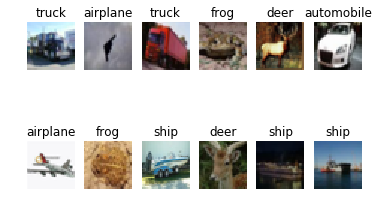

In [9]:
#隨機抽取12張圖來看一下
num_figures_display=12
fig_indexes=np.random.choice(x_train.shape[0],num_figures_display)

fig,axes=plt.subplots(2,6)
for fig_idx,axis in zip(fig_indexes,axes.reshape(-1) ):
    axis.axis('off')
    axis.imshow(x_train[fig_idx])
    axis.set_title(idx_to_label[ y_train[fig_idx] ])

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='02'> 將圖片做resize以及normalization </a>

In [10]:
import cv2
from keras.utils import to_categorical

# 做normalization。
# 一個簡單的方式，是將x直接除以255，使得x內的所有值均分佈於[0,1]之間。
x_train=x_train/255.
x_test=x_test/255.

# 調整x_train每張圖的大小從(32,32)乘以三倍，變成(96,96)。
x_train_resized=np.zeros((50000, 96, 96, 3),dtype=np.float16)
for idx,img in enumerate(x_train):
    if idx%10000==0:
        print(idx)
    x_train_resized[idx,:] = cv2.resize(img, None, fx=3, fy=3, interpolation = cv2.INTER_AREA)

# 調整x_test每張圖的大小從(32,32)乘以三倍，變成(96,96)。
x_test_resized=np.zeros((10000, 96, 96, 3),dtype=np.float16)
for idx,img in enumerate(x_test):
    if idx%1000==0:
        print(idx)
    x_test_resized[idx,:] = cv2.resize(img, None, fx=3, fy=3, interpolation = cv2.INTER_AREA)

# 將y轉換成為one hot的形式
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

0
10000
20000
30000
40000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='03'> 以```Sequential()```逐層疊加出CNN模型 </a>

In [11]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation

class MY_CNN(object):
    '''建立一個CNN模型'''
    def __init__(self,in_shape,out_classes):
        
        self.in_shape=in_shape
        self.out_classes=out_classes
        
    def build_model(self):
        '''以Sequential()逐層疊加模型。'''
        
        model = Sequential()
        # conv block 1
        model.add(Conv2D(32, (3, 3), padding="same",activation="relu",
                                     input_shape=self.in_shape) )
        model.add(Conv2D(32, (3, 3),activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # conv block 2
        model.add(Conv2D(64, (3, 3), padding='same',activation="relu"))
        model.add(Conv2D(64, (3, 3),activation="relu") )
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # dense block
        model.add(Flatten())
        model.add(Dense(512,activation="relu") )
        model.add(Dropout(0.5))
        model.add(Dense(self.out_classes))
        model.add(Activation('softmax'))
        return model

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 144us/step - loss: 1.6333 - acc: 0.3998 - val_loss: 1.2535 - val_acc: 0.5524
Epoch 2/20
50000/50000 [==============================] - 5s 105us/step - loss: 1.2150 - acc: 0.5648 - val_loss: 0.9951 - val_acc: 0.6467
Epoch 3/20
50000/50000 [==============================] - 5s 104us/step - loss: 1.0206 - acc: 0.6409 - val_loss: 0.8751 - val_acc: 0.6968
Epoch 4/20
50000/50000 [==============================] - 5s 105us/step - loss: 0.9054 - acc: 0.6807 - val_loss: 0.8323 - val_acc: 0.7084
Epoch 5/20
50000/50000 [==============================] - 5s 107us/step - loss: 0.8294 - acc: 0.7090 - val_loss: 0.7905 - val_acc: 0.7266
Epoch 6/20
50000/50000 [==============================] - 5s 101us/step - loss: 0.7663 - acc: 0.7311 - val_loss: 0.7051 - val_acc: 0.7514
Epoch 7/20
50000/50000 [==============================] - 5s 103us/step - loss: 0.7227 - acc: 0.7470 - val_loss: 0.7104 - 

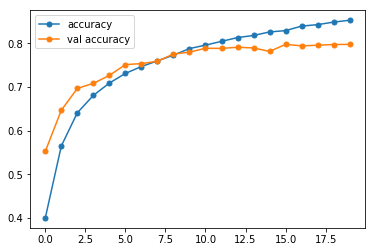

In [12]:
# 取得模型
model=MY_CNN(in_shape=(32,32,3),out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
# 訓練模型
history=model.fit(x=x_train, y=y_train_one_hot,validation_data=(x_test,y_test_one_hot),epochs=20,batch_size=128)
#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

# <a id='031'> 評估模型好壞 </a>

看metrics，如f1, precision, recall的表現:

In [18]:
predY=model.predict(x_test).argmax(axis=1)

from sklearn.metrics import classification_report
print( classification_report(predY,y_test) )

             precision    recall  f1-score   support

          0       0.83      0.82      0.83      1005
          1       0.88      0.93      0.90       946
          2       0.65      0.76      0.70       852
          3       0.66      0.61      0.64      1086
          4       0.79      0.74      0.77      1058
          5       0.76      0.66      0.71      1153
          6       0.78      0.89      0.83       875
          7       0.85      0.83      0.84      1026
          8       0.87      0.91      0.89       954
          9       0.90      0.86      0.88      1045

avg / total       0.80      0.80      0.80     10000



看accuracy的表現:

In [26]:
# 練習於此 
# 提示：使用model.predict(...)或model.evaluate(...)
loss, acc = model.evaluate(x_test, y_test_one_hot)
print(loss, acc)
acc_rate = (predY == y_test).sum()/len(y_test)
acc_rate

10000/10000 [==============================] - 1s 112us/step
0.6154249267578125 0.7978


0.7978

隨機抽取12張圖來看一下:

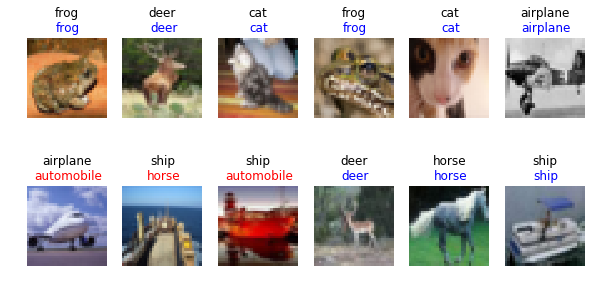

In [25]:
num_figures_display=12
fig_indexes=np.random.choice(x_test.shape[0],num_figures_display)

#建立 2X6 子圖
fig,axes=plt.subplots(2,6,figsize=(10,5))
for fig_idx,axis in zip(fig_indexes,axes.reshape(-1) ):
    axis.axis('off')
    axis.imshow(x_test[fig_idx])              # 畫圖
    label=idx_to_label[ y_test[fig_idx] ]     # 取得真實標籤
    pred_label=idx_to_label[ predY[fig_idx] ] # 取得預測標籤
    
    # 畫出真實標籤和預測標籤
    if label != pred_label:
        axis.text(16,-3, pred_label, fontsize='large', color='r', ha ='center')
    else:
        axis.text(16,-3, pred_label, fontsize='large', color='b', ha ='center')
    axis.set_title(label+"\n")

## <a id='04'>以```Model(input,output)```建構出CNN模型 </a>

In [28]:
from keras.models import Model
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Input

class MY_CNN(object):
    '''建立一個CNN模型'''
    def __init__(self,in_shape,out_classes):
        
        self.in_shape=in_shape
        self.out_classes=out_classes
        
    def build_model(self):
        '''以Sequential()逐層疊加模型。'''
        
        image = Input(self.in_shape)
        # conv block 1
        conv1=Conv2D(32, (3, 3), padding="same",activation="relu")
        conv2=Conv2D(32, (3, 3),activation="relu")
        pool1=MaxPooling2D(pool_size=(2, 2))
        dropout=Dropout(0.25)
        
        x=dropout(
            pool1(
                conv2(
                    conv1(image))))
        # conv block 2
        conv1=Conv2D(64, (3, 3), padding="same",activation="relu")
        conv2=Conv2D(64, (3, 3),activation="relu")
        pool1=MaxPooling2D(pool_size=(2, 2))
        dropout=Dropout(0.25)
        x=dropout(
            pool1(
                conv2(
                    conv1(x))))
        # dense block
        x=Dense(self.out_classes,activation="softmax")(
            Dropout(0.5)(
                Dense(512,activation="relu")(
                    Flatten()(x))))
        model=Model(image,x)
        return model

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='05'> 將CNN模型模組化</a>

In [29]:
from keras.models import Model
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Input

class MY_CNN(object):
    '''建立一個CNN模型。'''
    def __init__(self,in_shape,out_classes):
        
        self.in_shape=in_shape
        self.out_classes=out_classes

    def conv_block(self,n,x):
        '''建構convolution block。'''
        conv1=Conv2D(n, (3, 3), padding="same",activation="relu")
        conv2=Conv2D(n, (3, 3),activation="relu")
        pool1=MaxPooling2D(pool_size=(2, 2))
        dropout=Dropout(0.25)
        x=dropout(
            pool1(
                conv2(
                    conv1(x))))
        return x

    def build_model(self):
        '''以Model(input,output)的方式建立模型。'''
        
        image = Input(self.in_shape) # input image
        x=self.conv_block(32,image)  # conv block 1
        x=self.conv_block(64,x)      # conv block 2
        
        # dense block
        x=Dense(self.out_classes,activation="softmax")(
            Dropout(0.5)(
                Dense(512,activation="relu")(
                    Flatten()(x))))
        # build the model out of the graph, given tne input/output tensor
        model=Model(image,x)
        return model

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 126us/step - loss: 1.5958 - acc: 0.4160 - val_loss: 1.2617 - val_acc: 0.5456
Epoch 2/20
50000/50000 [==============================] - 5s 108us/step - loss: 1.2213 - acc: 0.5643 - val_loss: 1.0430 - val_acc: 0.6292
Epoch 3/20
50000/50000 [==============================] - 6s 111us/step - loss: 1.0508 - acc: 0.6272 - val_loss: 0.9143 - val_acc: 0.6801
Epoch 4/20
50000/50000 [==============================] - 5s 107us/step - loss: 0.9416 - acc: 0.6640 - val_loss: 0.9108 - val_acc: 0.6848
Epoch 5/20
50000/50000 [==============================] - 5s 108us/step - loss: 0.8656 - acc: 0.6960 - val_loss: 0.7939 - val_acc: 0.7229
Epoch 6/20
50000/50000 [==============================] - 5s 107us/step - loss: 0.7910 - acc: 0.7234 - val_loss: 0.7280 - val_acc: 0.7492
Epoch 7/20
50000/50000 [==============================] - 5s 107us/step - loss: 0.7393 - acc: 0.7408 - val_loss: 0.7135 - 

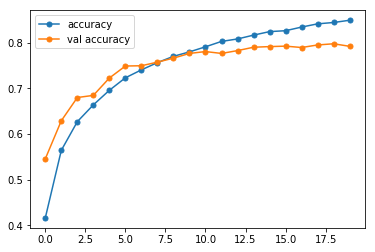

In [30]:
# 取得模型
model=MY_CNN(in_shape=(32,32,3),out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
# 訓練模型
history=model.fit(x=x_train, y=y_train_one_hot,validation_data=(x_test,y_test_one_hot),epochs=20,batch_size=128)
#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

以下我們嘗試將一個cnn block換成inception block (GoogleNet內部的主要架構)，看訓練模型會有什麼樣的結果。

## <a id='06'>將MY_CNN內的一個conv block換成inception block</a>

In [37]:
from keras.models import Model
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Input, Concatenate

class MY_CNN_INCEPT_BLOCK(object):
    '''建立一個CNN模型'''
    def __init__(self,in_shape,out_classes):
        
        self.in_shape=in_shape
        self.out_classes=out_classes

    def conv_block(self,n,x):
        
        conv1=Conv2D(n, (3, 3), padding="same",activation="relu")
        conv2=Conv2D(n, (3, 3),activation="relu")
        pool1=MaxPooling2D(pool_size=(2, 2))
        dropout=Dropout(0.25)
        x=dropout(
            pool1(
                conv2(
                    conv1(x))))
        return x
    
    def inception_block(self, x, n1_1, n2_1, n2_3, n3_1, n3_5, n4_1):

        path1_conv_1=Conv2D(n1_1,(1,1),activation="relu")
        path2_conv_1=Conv2D(n2_1,(1,1), activation="relu")
        path2_conv_3=Conv2D(n2_3,(3,3),padding='same', activation="relu")
        path3_conv_1=Conv2D(n3_1,(1,1), activation="relu")
        path3_conv_5=Conv2D(n3_5,(5,5),padding='same', activation="relu")
        path4_pool_3=MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding='same')
        path4_conv_1=Conv2D(n4_1,(1,1), activation="relu")

        path1=path1_conv_1(x)
        path2=path2_conv_3(path2_conv_1(x))
        path3=path3_conv_5(path3_conv_1(x))
        path4=path4_conv_1(path4_pool_3(x))
        return Concatenate(axis=-1)([path1,path2,path3,path4])
    def build_model(self):
        '''以Model(input,output)的方式建立模型。'''
        
        image = Input(self.in_shape) # input image
#         x=self.conv_block(32,image)  # conv block
        x=self.inception_block(image, 8, 12, 16, 2, 4, 4)
        x=self.inception_block(x, 8, 12, 16, 2, 4, 4) # inception block
        # entering into the dense block
        x=Dense(self.out_classes,activation="softmax")(
            Dropout(0.5)(
                Dense(512,activation="relu")(
                    Flatten()(x))))
        # build the model out of the graph, given tne input/output tensor
        model=Model(image,x)
        return model

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 246us/step - loss: 1.6049 - acc: 0.4269 - val_loss: 1.2515 - val_acc: 0.5599
Epoch 2/20
50000/50000 [==============================] - 10s 199us/step - loss: 1.2503 - acc: 0.5572 - val_loss: 1.1118 - val_acc: 0.6075
Epoch 3/20
50000/50000 [==============================] - 10s 199us/step - loss: 1.1099 - acc: 0.6051 - val_loss: 1.0634 - val_acc: 0.6251
Epoch 4/20
50000/50000 [==============================] - 10s 194us/step - loss: 0.9872 - acc: 0.6479 - val_loss: 1.0316 - val_acc: 0.6290
Epoch 5/20
50000/50000 [==============================] - 10s 193us/step - loss: 0.8864 - acc: 0.6862 - val_loss: 0.9851 - val_acc: 0.6533
Epoch 6/20
50000/50000 [==============================] - 10s 194us/step - loss: 0.7863 - acc: 0.7207 - val_loss: 1.0108 - val_acc: 0.6499
Epoch 7/20
50000/50000 [==============================] - 10s 193us/step - loss: 0.6982 - acc: 0.7499 - val_loss: 0.

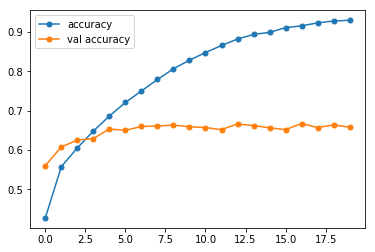

In [38]:
# 取得模型
model=MY_CNN_INCEPT_BLOCK(in_shape=(32,32,3),out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
# 訓練模型
history=model.fit(x=x_train, y=y_train_one_hot,validation_data=(x_test,y_test_one_hot),epochs=20,batch_size=128)
#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

可見此模型有非常嚴重的overfitting。以下我們試著以data augmentation 來對抗overfitting：

## <a id='07'>以data augmentation的方式來對抗overfitting </a>

In [ ]:
# 取得模型
model=MY_CNN_INCEPT_BLOCK(in_shape=(32,32,3),out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

# image data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(x_train)

# 將圖像包成generator。這可以使得圖像能夠被批次的抽取出來，
# 接著做完augmentation後，隨即丟給模型做訓練。
generator=datagen.flow(x_train, y_train_one_hot,batch_size=128)
# 訓練模型
history=model.fit_generator(generator,
                    epochs=20,
                    validation_data=(x_test, y_test_one_hot),
                    workers=6)
#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='08'>拿Keras內建的VGG16模型架構來建立模型</a>

```keras.applications```裡面內建了一些常見的架構，如VGG,GoogleNet, ResNet等。以下我們嘗試來使用VGG16建立模型：

In [ ]:
rand_fig_idx=np.random.choice(x_train_resized.shape[0])
plt.imshow( (x_train_resized[rand_fig_idx]*255).astype(np.uint8) )
idx_to_label[y_train[rand_fig_idx]]

In [ ]:
from keras.applications import VGG16
from keras import Model
from keras.optimizers import SGD

In [ ]:
# model=VGG16(include_top=True,input_shape=(96,96,3),weights=None)
# model.summary()

In [ ]:
# 取得內建的VGG模型 (去掉後層分類器的部分)
model=VGG16(include_top=False,input_shape=(96,96,3),weights=None)
# 添加後層分類器至內建VGG模型
last = model.output
x = Flatten()(last)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(10, activation='softmax')(x)
# 組合模型
model = Model(model.input, preds)
# 編譯模型，告知模型訓練方式
model.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
rec=model.fit(x=x_train_resized, y=y_train_one_hot,
                  validation_data=(x_test_resized,y_test_one_hot),
                  epochs=2,batch_size=128)

In [ ]:
#畫出訓練過程
# plt.plot(rec.history['acc'],ms=5,marker='o',label='accuracy')
# plt.plot(rec.history['val_acc'],ms=5,marker='o',label='val accuracy')
# plt.legend()
# plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)